In [1]:
paste("R version is:", paste0(R.Version()[c("major","minor")], collapse = "."))

[1] "R version is: 4.0.2"

## Predicting outcomes by splitting data

In [2]:
# installing feather library, if not yet available
if (!("feather" %in% rownames(installed.packages()))) {
    install.packages("feather")
}

In [3]:
# installing RCurl library, if not yet available
if (!("RCurl" %in% rownames(installed.packages()))) {
    install.packages("RCurl")
}

In [4]:
library(feather)
library(RCurl)

url <- "https://github.com/lmassaron/datasets/releases/download/1.0/wine_quality.feather"
destfile <- "wine_quality.feather"
download.file(url, destfile, mode =  "wb")

wine <- read_feather(destfile)

Warning message:
"Coercing int64 to double"
Warning message:
"Coercing int64 to double"


In [5]:
y <- wine$quality
X <- as.data.frame(wine[,2:ncol(wine)])

# Splitting the data frame into train and test sets
set.seed(42)
sample_size <- floor(0.7 * nrow(X))
train_idx <- sample(seq_len(nrow(X)), size = sample_size)

X_train <- X[train_idx,]
y_train <- y[train_idx]
X_test  <- X[-train_idx,]
y_test  <- y[-train_idx]

In [6]:
# installing randomForest library, if not yet available
if (!("randomForest" %in% rownames(installed.packages()))) {
    install.packages("randomForest")
}

In [7]:
# installing MLmetrics library, if not yet available
if (!("MLmetrics" %in% rownames(installed.packages()))) {
    install.packages("MLmetrics")
}

In this first experiment we try various random forest models, each one having an increasing number of trees.

In [8]:
library(randomForest)
library(MLmetrics)

test_scores <- NULL
for (trees in c(10, 25, 50, 100, 150, 200, 250, 300, 500)) {
    rf = randomForest(X_train, y_train, ntree=trees)
    test_scores <- c(test_scores, MAE(y_pred=predict(rf, X_test), 
                                      y_true=y_test))
}

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'MLmetrics'


The following object is masked from 'package:base':

    Recall




We plot the results and notice that as we increment the number of tree in the forest so does the test scores.

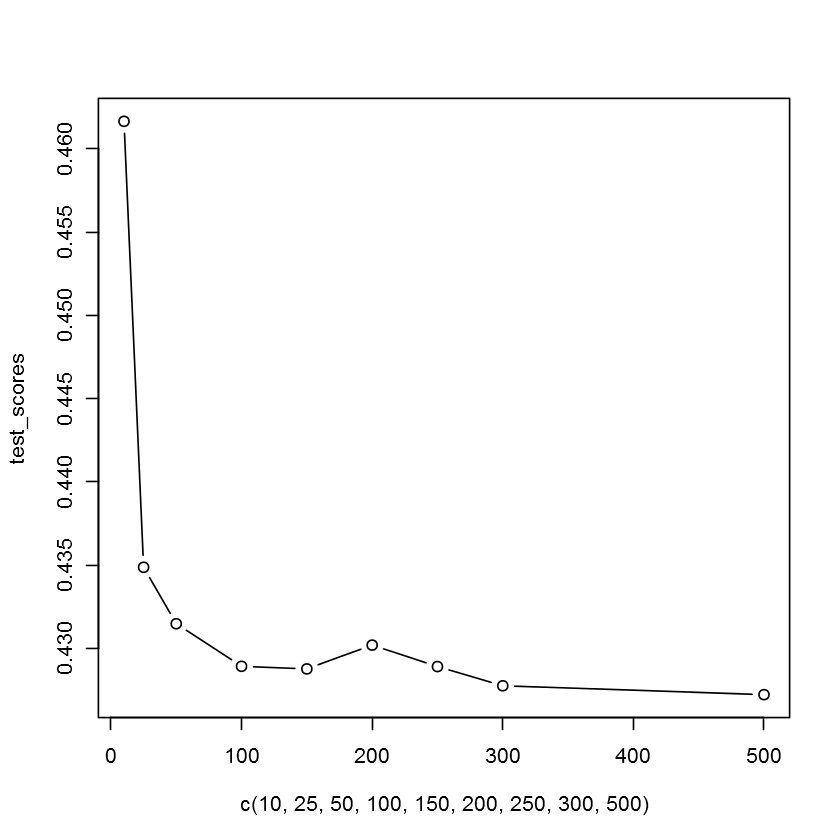

In [9]:
plot(c(10, 25, 50, 100, 150, 200, 250, 300, 500), 
     test_scores, type='b')

## Understanding the importance measures

In order to examine the importance derived from the random forest model, you have first to state the parameter importance as TRUE.

In [10]:
rf = randomForest(X_train, y_train, 
                  ntree=500, mtry=sqrt(ncol(X_train)),
                  importance=TRUE)

Since the caret library masks the MAE from MLmetrics, we have to call it directly from the MLmetrics library.

In [11]:
MLmetrics::MAE(y_pred=predict(rf, X_test), y_true=y_test)

[1] 0.428978

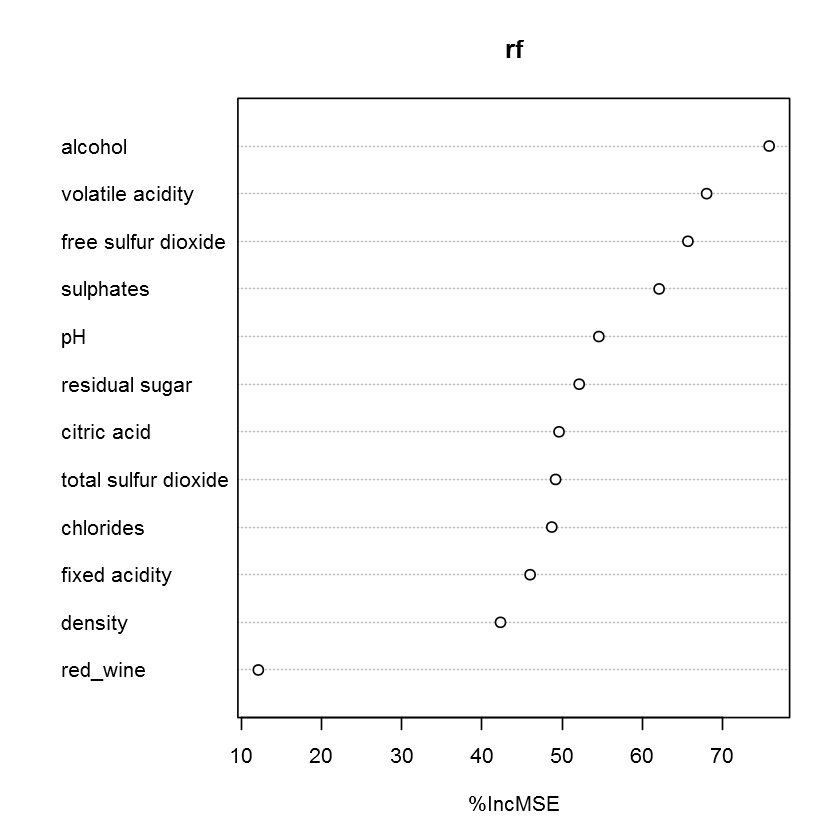

In [12]:
varImpPlot(rf, type=1)

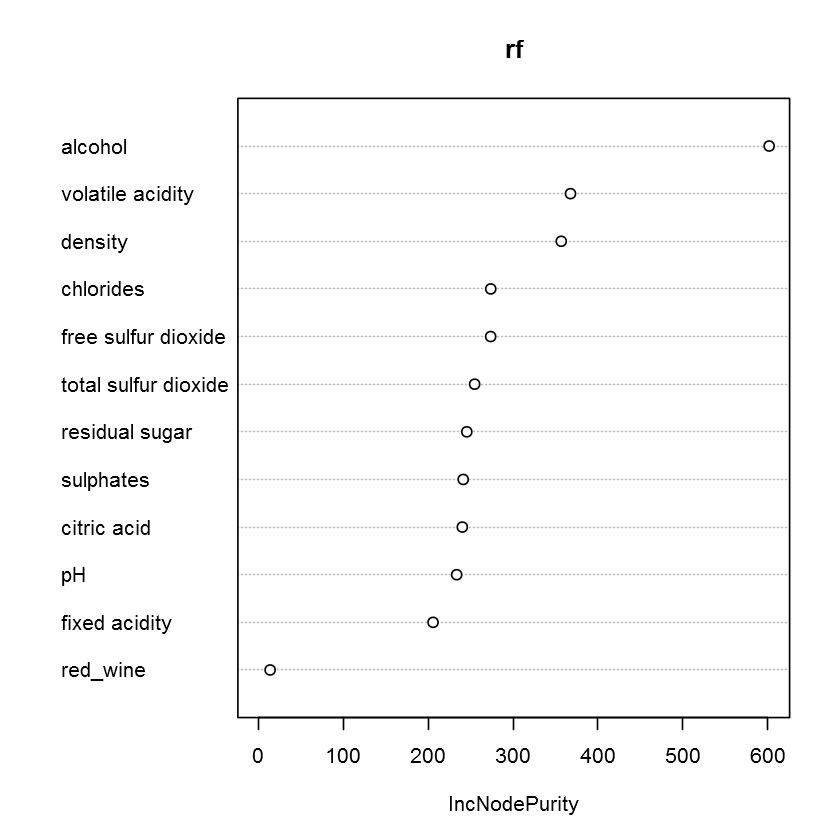

In [13]:
varImpPlot(rf, type=2)

## Adaboost with different base learners

In [14]:
# installing caret library, if not yet available
if (!("caret" %in% rownames(installed.packages()))) {
    install.packages("caret")
}

In [15]:
# installing ipred library, if not yet available
if (!("ipred" %in% rownames(installed.packages()))) {
    install.packages("ipred")
}

In [16]:
# installing plyr library, if not yet available
if (!("plyr" %in% rownames(installed.packages()))) {
    install.packages("plyr")
}

In [17]:
# installing e1071 library, if not yet available
if (!("e1071" %in% rownames(installed.packages()))) {
    install.packages("e1071")
}

In [ ]:
# installing adabag library, if not yet available
if (!("adabag" %in% rownames(installed.packages()))) {
    install.packages("e1071")
}

Apart from caret, most of the libraries are for running adabag and the treebag model which allows working on regression models, contrary to most adaboost models available in R limited to just binary classification.

In [18]:
library(caret)
library(adabag)

ada_model <- train(X_train, y_train, method="treebag",
                   trControl=trainControl(method="cv", number=3),
                   metric = "MAE")

print(ada_model)

Loading required package: lattice

Loading required package: ggplot2


Attaching package: 'ggplot2'


The following object is masked from 'package:randomForest':

    margin



Attaching package: 'caret'


The following objects are masked from 'package:MLmetrics':

    MAE, RMSE


Loading required package: rpart

Loading required package: foreach

Loading required package: doParallel

Loading required package: iterators

Loading required package: parallel



Bagged CART 

4547 samples
  12 predictor

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 3031, 3032, 3031 
Resampling results:

  RMSE       Rsquared   MAE      
  0.7471535  0.2754201  0.5939229



In [19]:
MLmetrics::MAE(y_pred=predict(ada_model, X_test), y_true=y_test)

[1] 0.5807229

##  Testing Gradient boosting performance

In [20]:
# installing gbm library, if not yet available
if (!("gbm" %in% rownames(installed.packages()))) {
    install.packages("gbm")
}

In this experiment we use gbm (https://www.rdocumentation.org/packages/gbm/versions/2.1.8/topics/gbm), setting our model to 500 trees, interactions up to 12 branches, a minimum of 30 observations for node before splitting. You can change the paramaters or remove the tuneGrid and let the caret library find the best for you (it may take a while). 

In [21]:
library(caret)
library(gbm)

gbm_model<-train(X_train, y_train, method="gbm",
                 trControl=trainControl(method="cv", number=3),
                 tuneGrid=data.frame(n.trees=500, 
                                     interaction.depth=12, 
                                     shrinkage=0.1,
                                     n.minobsinnode=30),
                 metric="MAE")

print(gbm_model)

Loaded gbm 2.1.8



Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.7194             nan     0.1000    0.0400
     2        0.6832             nan     0.1000    0.0311
     3        0.6509             nan     0.1000    0.0291
     4        0.6247             nan     0.1000    0.0220
     5        0.6026             nan     0.1000    0.0197
     6        0.5824             nan     0.1000    0.0175
     7        0.5657             nan     0.1000    0.0138
     8        0.5516             nan     0.1000    0.0104
     9        0.5393             nan     0.1000    0.0102
    10        0.5289             nan     0.1000    0.0071
    20        0.4541             nan     0.1000    0.0028
    40        0.3901             nan     0.1000    0.0004
    60        0.3551             nan     0.1000   -0.0003
    80        0.3297             nan     0.1000   -0.0008
   100        0.3078             nan     0.1000   -0.0013
   120        0.2886             nan     0.1000   -0.0011
   140        

Stochastic Gradient Boosting 

4547 samples
  12 predictor

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 3031, 3031, 3032 
Resampling results:

  RMSE       Rsquared   MAE      
  0.6919648  0.3887064  0.5238877

Tuning parameter 'n.trees' was held constant at a value of 500
Tuning

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held constant at a value of 30


In [22]:
MLmetrics::MAE(y_pred=predict(gbm_model, X_test), y_true=y_test)

[1] 0.4685418

## Blending solutions together

In [23]:
# installing gbm kernlab, if not yet available
if (!("kernlab" %in% rownames(installed.packages()))) {
    install.packages("kernlab")
}

In our blend we average (50%-50%) two different models: a gbm and a support vector machine.

In [24]:
library(caret)
library(gbm)

gbm_model<-train(X_train, y_train, method="gbm",
                 trControl=trainControl(method="cv", number=3),
                 tuneGrid=data.frame(n.trees=500, 
                                     interaction.depth=12, 
                                     shrinkage=0.1,
                                     n.minobsinnode=30),
                 metric="MAE")

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.7316             nan     0.1000    0.0421
     2        0.6920             nan     0.1000    0.0332
     3        0.6595             nan     0.1000    0.0285
     4        0.6344             nan     0.1000    0.0208
     5        0.6118             nan     0.1000    0.0174
     6        0.5929             nan     0.1000    0.0157
     7        0.5779             nan     0.1000    0.0119
     8        0.5627             nan     0.1000    0.0113
     9        0.5498             nan     0.1000    0.0093
    10        0.5394             nan     0.1000    0.0079
    20        0.4733             nan     0.1000    0.0010
    40        0.4157             nan     0.1000    0.0005
    60        0.3793             nan     0.1000   -0.0008
    80        0.3529             nan     0.1000   -0.0007
   100        0.3284             nan     0.1000   -0.0017
   120        0.3074             nan     0.1000   -0.0012
   140        

In [25]:
library(kernlab)

svm_model <- train(X_train, y_train, method="svmRadialSigma",
                   trControl=trainControl(method="cv", number=3),
                   metric="MAE")

print(svm_model)


Attaching package: 'kernlab'


The following object is masked from 'package:ggplot2':

    alpha




Support Vector Machines with Radial Basis Function Kernel 

4547 samples
  12 predictor

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 3031, 3031, 3032 
Resampling results across tuning parameters:

  sigma       C     RMSE       Rsquared   MAE      
  0.02312148  0.25  0.7211465  0.3247628  0.5594620
  0.02312148  0.50  0.7159453  0.3342053  0.5538372
  0.02312148  1.00  0.7116715  0.3423323  0.5488639
  0.08948082  0.25  0.7032589  0.3583254  0.5375561
  0.08948082  0.50  0.6967092  0.3702684  0.5296020
  0.08948082  1.00  0.6919387  0.3790266  0.5238594
  0.15584016  0.25  0.7011237  0.3628037  0.5314223
  0.15584016  0.50  0.6938686  0.3750013  0.5229403
  0.15584016  1.00  0.6906146  0.3811155  0.5186656

MAE was used to select the optimal model using the smallest value.
The final values used for the model were sigma = 0.1558402 and C = 1.


predictions are simply summed after having weighted each one. In this case we used the same weight (0.5) but you can test differnt weights for better results. The only important thing is that the sum of the weights should always be 1.0.

In [27]:
preds <- 0.5 * predict(gbm_model, X_test) + 0.5 * predict(svm_model, X_test)

In [28]:
MLmetrics::MAE(y_pred=preds, y_true=y_test)

[1] 0.4627765

## Stacking solutions together

In [29]:
# installing SuperLearner library, if not yet available
if (!("SuperLearner" %in% rownames(installed.packages()))) {
    install.packages("SuperLearner")
}

In [30]:
# installing extraTrees library, if not yet available
if (!("extraTrees" %in% rownames(installed.packages()))) {
    install.packages("extraTrees")
}

In [31]:
# installing xgboost library, if not yet available
if (!("xgboost" %in% rownames(installed.packages()))) {
    install.packages("xgboost")
}

Our final model ensembles into a stacking solution extraTrees, an extremely randomized version of RandomForests, a Support Vector Machine and XGBoost, a particularly performant version of gradient boosting (https://xgboost.readthedocs.io/en/latest/).

In [32]:
library(SuperLearner)

SL.library <- c("SL.extraTrees", "SL.svm", "SL.xgboost")
stacked_ensemble <- SuperLearner(Y=y_train, X=X_train, newX=X_test, SL.library=SL.library,
                                 verbose=TRUE, family='gaussian', method="method.NNLS")

Loading required package: nnls

Super Learner

Version: 2.0-26

Package created on 2019-10-27


Number of covariates in All is: 12

Loading required namespace: extraTrees

CV SL.extraTrees_All

CV SL.svm_All

Loading required namespace: xgboost



[17:14:01] WARNING: amalgamation/../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


CV SL.xgboost_All

Number of covariates in All is: 12

CV SL.extraTrees_All

CV SL.svm_All



[17:14:39] WARNING: amalgamation/../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


CV SL.xgboost_All

Number of covariates in All is: 12

CV SL.extraTrees_All

CV SL.svm_All



[17:15:09] WARNING: amalgamation/../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


CV SL.xgboost_All

Number of covariates in All is: 12

CV SL.extraTrees_All

CV SL.svm_All



[17:15:27] WARNING: amalgamation/../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


CV SL.xgboost_All

Number of covariates in All is: 12

CV SL.extraTrees_All

CV SL.svm_All



[17:15:45] WARNING: amalgamation/../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


CV SL.xgboost_All

Number of covariates in All is: 12

CV SL.extraTrees_All

CV SL.svm_All



[17:16:02] WARNING: amalgamation/../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


CV SL.xgboost_All

Number of covariates in All is: 12

CV SL.extraTrees_All

CV SL.svm_All



[17:16:20] WARNING: amalgamation/../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


CV SL.xgboost_All

Number of covariates in All is: 12

CV SL.extraTrees_All

CV SL.svm_All



[17:16:37] WARNING: amalgamation/../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


CV SL.xgboost_All

Number of covariates in All is: 12

CV SL.extraTrees_All

CV SL.svm_All



[17:16:55] WARNING: amalgamation/../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


CV SL.xgboost_All

Number of covariates in All is: 12

CV SL.extraTrees_All

CV SL.svm_All



[17:17:14] WARNING: amalgamation/../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


CV SL.xgboost_All

Non-Negative least squares convergence: TRUE

full SL.extraTrees_All

full SL.svm_All



[17:17:34] WARNING: amalgamation/../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


full SL.xgboost_All



In [33]:
MLmetrics::MAE(y_pred=stacked_ensemble$SL.predict, y_true=y_test)

[1] 0.4127481